# Day 5: Data Manipulation and Analysis
## Notebook 4: Signal Processing and Timeseries

**Introduction to Scientific Programming**  
CNC-UC | 2025

This notebook covers:
- Filtering signals
- Smoothing techniques
- Peak detection
- Working with datetime data
- Resampling and rolling windows
- Shift, diff, and derivatives

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, ndimage

%matplotlib inline

print("Setup complete!")

Setup complete!


## 1. Signal Filtering

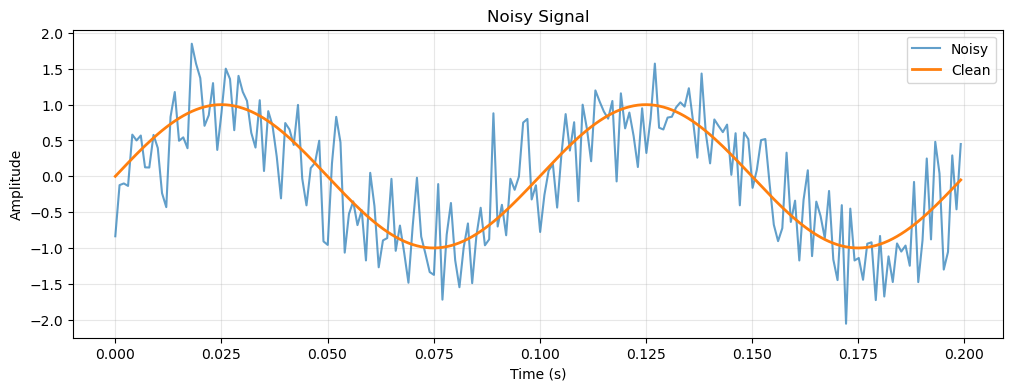

In [2]:
# Create noisy signal
fs = 1000  # Sampling rate (Hz)
t = np.linspace(0, 1, fs)
clean_signal = np.sin(2*np.pi*10*t)  # 10 Hz sine wave
noise = 0.5 * np.random.randn(fs)
noisy_signal = clean_signal + noise

plt.figure(figsize=(12, 4))
plt.plot(t[:200], noisy_signal[:200], label='Noisy', alpha=0.7)
plt.plot(t[:200], clean_signal[:200], label='Clean', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Noisy Signal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Low-pass filter

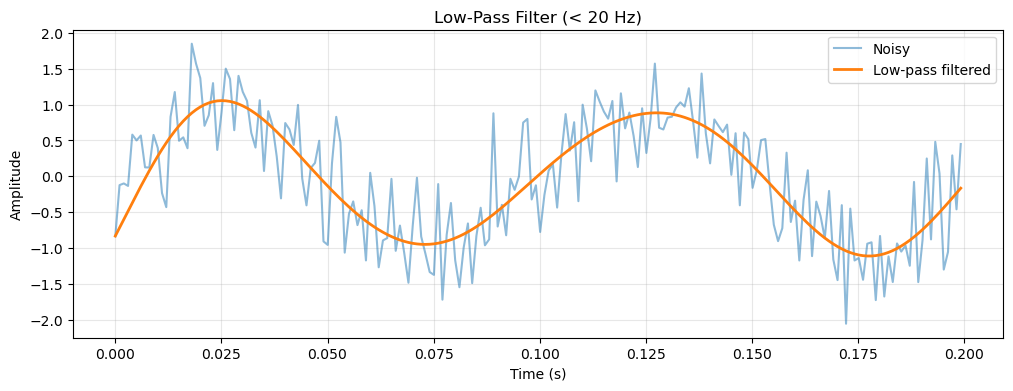

In [3]:
# Design low-pass filter
cutoff = 20  # Hz
nyquist = fs / 2
normalized_cutoff = cutoff / nyquist

b, a = signal.butter(4, normalized_cutoff, btype='low')
filtered_lowpass = signal.filtfilt(b, a, noisy_signal)

plt.figure(figsize=(12, 4))
plt.plot(t[:200], noisy_signal[:200], label='Noisy', alpha=0.5)
plt.plot(t[:200], filtered_lowpass[:200], label='Low-pass filtered', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Low-Pass Filter (< 20 Hz)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### High-pass filter

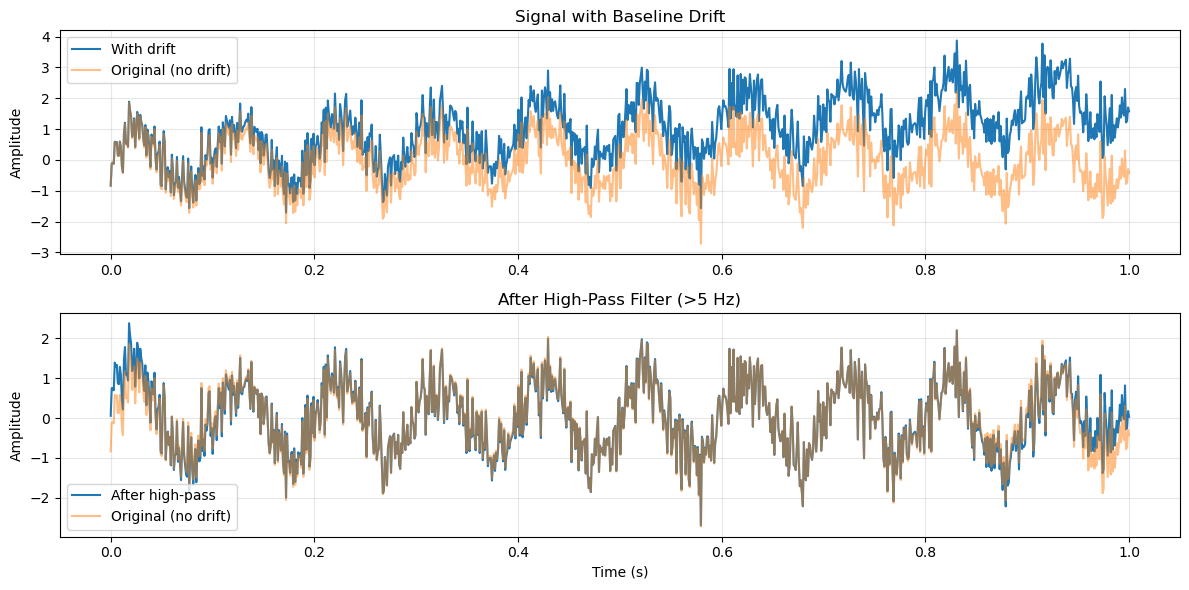

In [5]:
# Add baseline drift
drift = 2.0 * t  # Stronger drift
signal_with_drift = noisy_signal + drift

# High-pass filter to remove drift
cutoff_hp = 5  # Hz (higher cutoff for this short signal)
b_hp, a_hp = signal.butter(4, cutoff_hp/nyquist, btype='high')
filtered_highpass = signal.filtfilt(b_hp, a_hp, signal_with_drift)

fig, axes = plt.subplots(2, 1, figsize=(12, 6))
axes[0].plot(t, signal_with_drift, label='With drift')
axes[0].plot(t, noisy_signal, alpha=0.5, label='Original (no drift)')
axes[0].set_title('Signal with Baseline Drift')
axes[0].set_ylabel('Amplitude')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(t, filtered_highpass, label='After high-pass')
axes[1].plot(t, noisy_signal, alpha=0.5, label='Original (no drift)')
axes[1].set_title(f'After High-Pass Filter (>{cutoff_hp} Hz)')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Band-pass filter

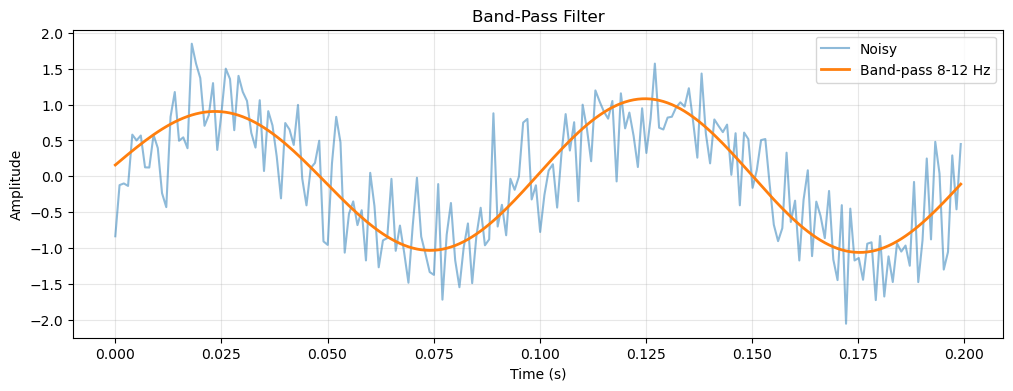

In [6]:
# Band-pass filter (isolate frequency band)
low_freq = 8  # Hz
high_freq = 12  # Hz

b_bp, a_bp = signal.butter(
    4, 
    [low_freq/nyquist, high_freq/nyquist],
    btype='band'
)
filtered_bandpass = signal.filtfilt(b_bp, a_bp, noisy_signal)

plt.figure(figsize=(12, 4))
plt.plot(t[:200], noisy_signal[:200], label='Noisy', alpha=0.5)
plt.plot(t[:200], filtered_bandpass[:200], label=f'Band-pass {low_freq}-{high_freq} Hz', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Band-Pass Filter')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 2. Smoothing Techniques

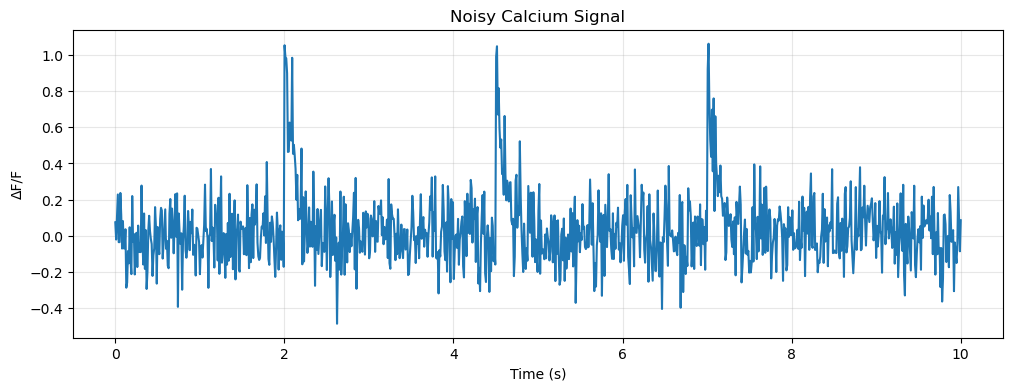

In [7]:
# Create calcium imaging-like signal
np.random.seed(42)
t_ca = np.linspace(0, 10, 1000)
ca_signal = np.zeros_like(t_ca)

# Add calcium transients
transient_times = [2, 4.5, 7]
for tt in transient_times:
    idx = int(tt * 100)
    ca_signal[idx:idx+50] += np.exp(-np.arange(50)/10)

# Add noise
ca_signal += 0.15 * np.random.randn(len(t_ca))

plt.figure(figsize=(12, 4))
plt.plot(t_ca, ca_signal)
plt.xlabel('Time (s)')
plt.ylabel('ΔF/F')
plt.title('Noisy Calcium Signal')
plt.grid(True, alpha=0.3)
plt.show()

### Moving average

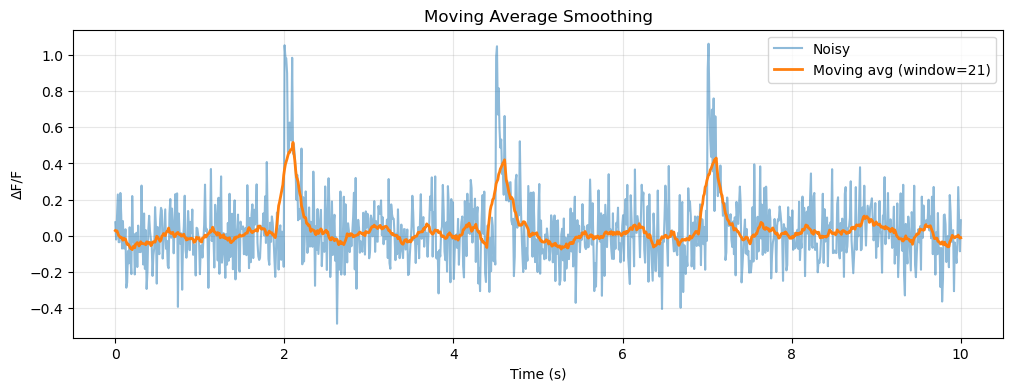

In [8]:
# Moving average
window = 21
smoothed_ma = np.convolve(ca_signal, np.ones(window)/window, mode='same')

plt.figure(figsize=(12, 4))
plt.plot(t_ca, ca_signal, alpha=0.5, label='Noisy')
plt.plot(t_ca, smoothed_ma, linewidth=2, label=f'Moving avg (window={window})')
plt.xlabel('Time (s)')
plt.ylabel('ΔF/F')
plt.title('Moving Average Smoothing')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Savitzky-Golay filter

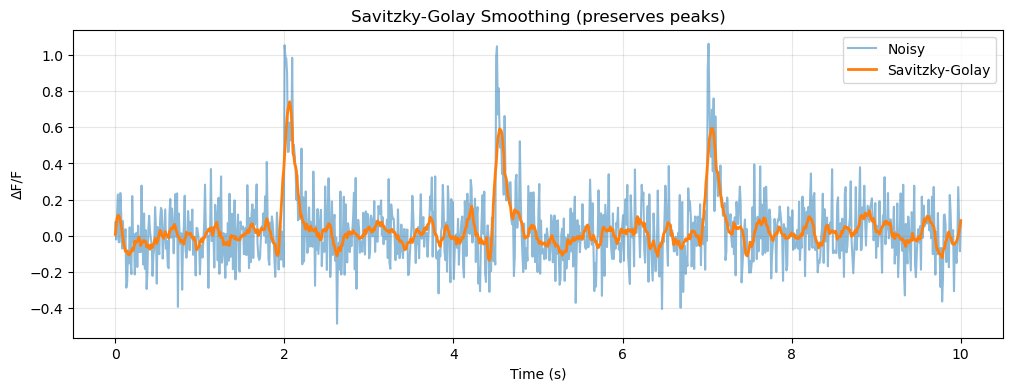

In [9]:
# Savitzky-Golay filter (preserves peaks)
smoothed_sg = signal.savgol_filter(ca_signal, window_length=21, polyorder=3)

plt.figure(figsize=(12, 4))
plt.plot(t_ca, ca_signal, alpha=0.5, label='Noisy')
plt.plot(t_ca, smoothed_sg, linewidth=2, label='Savitzky-Golay')
plt.xlabel('Time (s)')
plt.ylabel('ΔF/F')
plt.title('Savitzky-Golay Smoothing (preserves peaks)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Gaussian smoothing

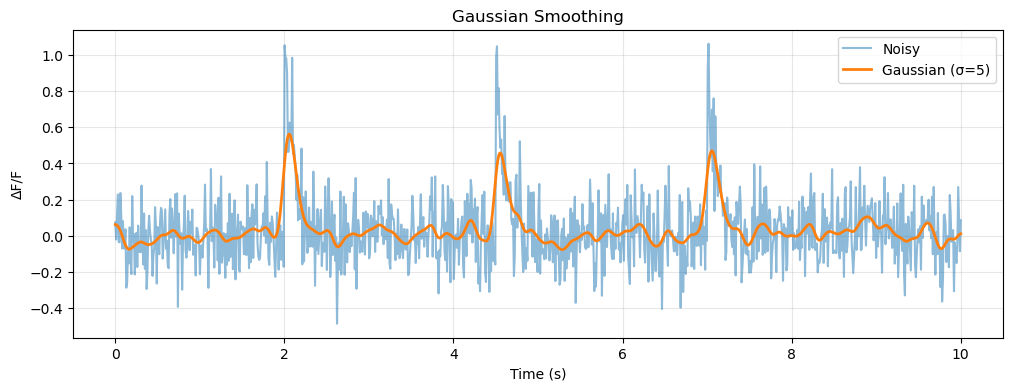

In [10]:
# Gaussian smoothing
sigma = 5
smoothed_gaussian = ndimage.gaussian_filter1d(ca_signal, sigma)

plt.figure(figsize=(12, 4))
plt.plot(t_ca, ca_signal, alpha=0.5, label='Noisy')
plt.plot(t_ca, smoothed_gaussian, linewidth=2, label=f'Gaussian (σ={sigma})')
plt.xlabel('Time (s)')
plt.ylabel('ΔF/F')
plt.title('Gaussian Smoothing')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Peak Detection

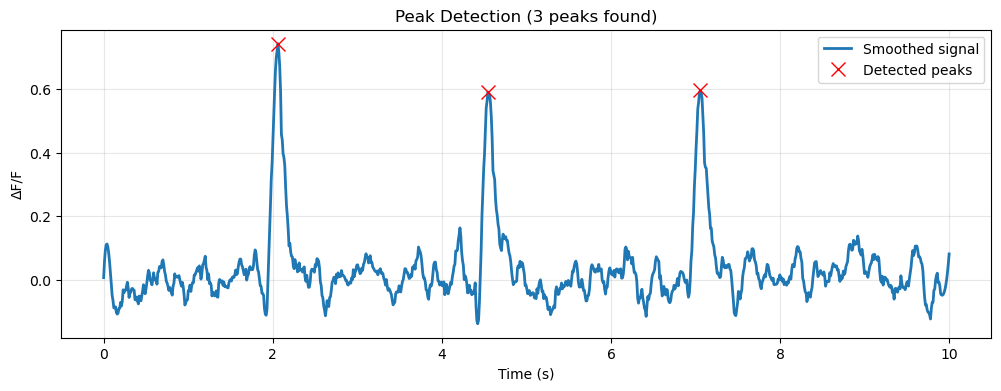

Peak times (s): [2.06206206 4.54454454 7.05705706]
Peak heights: [0.74130724 0.5899222  0.59468699]


In [11]:
# Detect peaks in calcium signal
peaks, properties = signal.find_peaks(
    smoothed_sg,
    height=0.3,
    distance=100,
    prominence=0.2
)

plt.figure(figsize=(12, 4))
plt.plot(t_ca, smoothed_sg, linewidth=2, label='Smoothed signal')
plt.plot(t_ca[peaks], smoothed_sg[peaks], 'rx', markersize=10, label='Detected peaks')
plt.xlabel('Time (s)')
plt.ylabel('ΔF/F')
plt.title(f'Peak Detection ({len(peaks)} peaks found)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Peak times (s): {t_ca[peaks]}")
print(f"Peak heights: {properties['peak_heights']}")

## 4. Working with Datetime Data

In [18]:
# Create timeseries data
dates = pd.date_range('2024-01-01', periods=100, freq='h')  
values = np.random.randn(100).cumsum() + 100

df_ts = pd.DataFrame({
    'timestamp': dates,
    'measurement': values
})

# Set timestamp as index
df_ts = df_ts.set_index('timestamp')

print("Timeseries data:")
print(df_ts.head())
print(f"\nIndex type: {type(df_ts.index)}")
print(f"Index freq: {df_ts.index.freq}")

Timeseries data:
                     measurement
timestamp                       
2024-01-01 00:00:00    99.331910
2024-01-01 01:00:00   100.323952
2024-01-01 02:00:00   100.148992
2024-01-01 03:00:00    99.393247
2024-01-01 04:00:00    99.929757

Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index freq: None


### Time-based slicing

In [20]:
# Time-based slicing
print("Single day (2024-01-01):")
print(df_ts.loc['2024-01-01'])
print(f"\nNumber of rows: {len(df_ts.loc['2024-01-01'])}")

print("\n" + "="*50)
print("Date range (2024-01-01 to 2024-01-02):")
print(df_ts.loc['2024-01-01':'2024-01-02'])
print(f"\nNumber of rows: {len(df_ts.loc['2024-01-01':'2024-01-02'])}")

Single day (2024-01-01):
                     measurement
timestamp                       
2024-01-01 00:00:00    99.331910
2024-01-01 01:00:00   100.323952
2024-01-01 02:00:00   100.148992
2024-01-01 03:00:00    99.393247
2024-01-01 04:00:00    99.929757
2024-01-01 05:00:00    99.031289
2024-01-01 06:00:00    99.059470
2024-01-01 07:00:00    99.050351
2024-01-01 08:00:00   100.136247
2024-01-01 09:00:00   100.610945
2024-01-01 10:00:00   100.585918
2024-01-01 11:00:00   101.403684
2024-01-01 12:00:00   102.793892
2024-01-01 13:00:00   103.351702
2024-01-01 14:00:00   103.362055
2024-01-01 15:00:00   102.050218
2024-01-01 16:00:00   100.985105
2024-01-01 17:00:00   100.679880
2024-01-01 18:00:00   100.070368
2024-01-01 19:00:00    99.883397
2024-01-01 20:00:00    99.940046
2024-01-01 21:00:00   100.469739
2024-01-01 22:00:00   100.399240
2024-01-01 23:00:00   100.885742

Number of rows: 24

Date range (2024-01-01 to 2024-01-02):
                     measurement
timestamp               

### Extract time components

In [21]:
# Extract time components
df_ts['hour'] = df_ts.index.hour
df_ts['day'] = df_ts.index.day
df_ts['dayofweek'] = df_ts.index.dayofweek  # 0=Monday

print("With time components:")
print(df_ts.head(10))

With time components:
                     measurement  hour  day  dayofweek
timestamp                                             
2024-01-01 00:00:00    99.331910     0    1          0
2024-01-01 01:00:00   100.323952     1    1          0
2024-01-01 02:00:00   100.148992     2    1          0
2024-01-01 03:00:00    99.393247     3    1          0
2024-01-01 04:00:00    99.929757     4    1          0
2024-01-01 05:00:00    99.031289     5    1          0
2024-01-01 06:00:00    99.059470     6    1          0
2024-01-01 07:00:00    99.050351     7    1          0
2024-01-01 08:00:00   100.136247     8    1          0
2024-01-01 09:00:00   100.610945     9    1          0


## 5. Resampling and Rolling Windows

### Downsampling

In [23]:
# Downsample to daily mean
df_daily = df_ts['measurement'].resample('1D').mean()

print("Daily averages:")
df_daily

Daily averages:


timestamp
2024-01-01    100.578214
2024-01-02     99.908969
2024-01-03     93.259367
2024-01-04     93.900762
2024-01-05     96.644670
Freq: D, Name: measurement, dtype: float64

### Upsampling

In [25]:
# Upsample to 30-minute intervals
df_upsampled = df_ts['measurement'].resample('30min').interpolate()

print(f"Original points: {len(df_ts)}")
print(f"Upsampled points: {len(df_upsampled)}")
print("\nFirst 10 upsampled values:")
df_upsampled.head(10)

Original points: 100
Upsampled points: 199

First 10 upsampled values:


timestamp
2024-01-01 00:00:00     99.331910
2024-01-01 00:30:00     99.827931
2024-01-01 01:00:00    100.323952
2024-01-01 01:30:00    100.236472
2024-01-01 02:00:00    100.148992
2024-01-01 02:30:00     99.771120
2024-01-01 03:00:00     99.393247
2024-01-01 03:30:00     99.661502
2024-01-01 04:00:00     99.929757
2024-01-01 04:30:00     99.480523
Freq: 30min, Name: measurement, dtype: float64

### Rolling windows

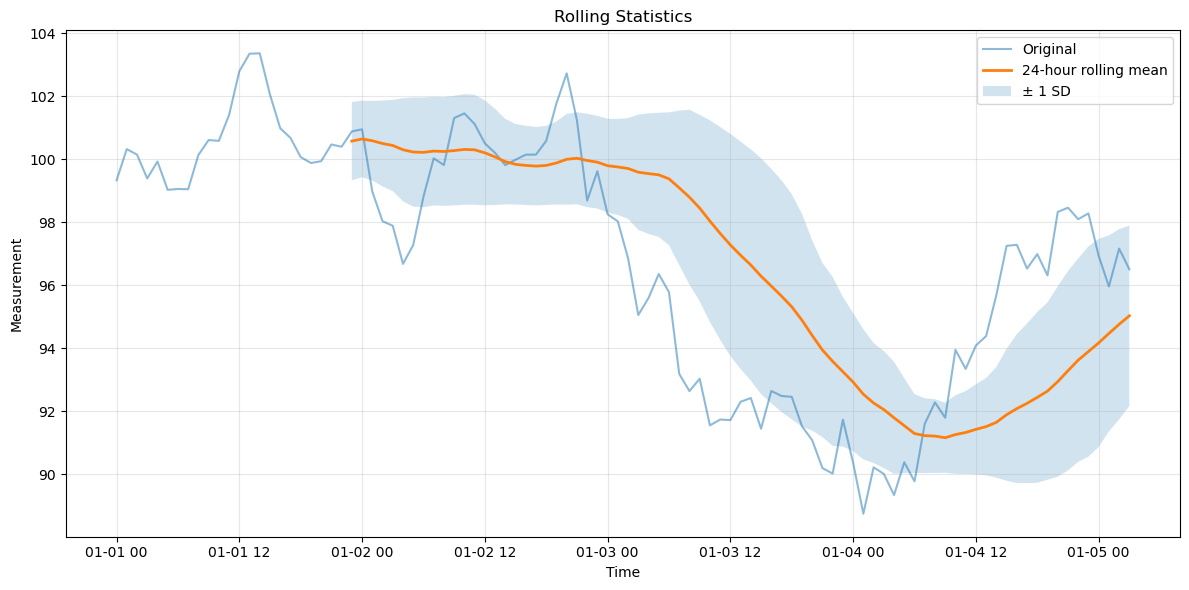

In [26]:
# Rolling statistics
df_ts['rolling_mean'] = df_ts['measurement'].rolling(window=24).mean()
df_ts['rolling_std'] = df_ts['measurement'].rolling(window=24).std()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_ts.index, df_ts['measurement'], alpha=0.5, label='Original')
plt.plot(df_ts.index, df_ts['rolling_mean'], linewidth=2, label='24-hour rolling mean')
plt.fill_between(
    df_ts.index,
    df_ts['rolling_mean'] - df_ts['rolling_std'],
    df_ts['rolling_mean'] + df_ts['rolling_std'],
    alpha=0.2,
    label='± 1 SD'
)
plt.xlabel('Time')
plt.ylabel('Measurement')
plt.title('Rolling Statistics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Shift, Diff, and Derivatives

In [27]:
# Create position data
t_pos = np.linspace(0, 10, 100)
position = 5 * t_pos + 2 * np.sin(t_pos) + 0.3 * np.random.randn(len(t_pos))

df_pos = pd.DataFrame({
    'time': t_pos,
    'position': position
})

print("Position data:")
df_pos.head()

Position data:


,time,position
0,0.00000,-0.314073
1,0.10101,0.867723
2,0.20202,1.767110
3,0.30303,2.327665
4,0.40404,3.105290


### Shift and difference

In [28]:
# Shift
df_pos['previous_position'] = df_pos['position'].shift(1)
df_pos['next_position'] = df_pos['position'].shift(-1)

# Difference
df_pos['change'] = df_pos['position'].diff()

print("With shift and diff:")
df_pos[['position', 'previous_position', 'next_position', 'change']].head(10)

With shift and diff:


,position,previous_position,next_position,change
0,-0.314073,NaN,0.867723,NaN
1,0.867723,-0.314073,1.767110,1.181796
2,1.767110,0.867723,2.327665,0.899387
3,2.327665,1.767110,3.105290,0.560555
4,3.105290,2.327665,3.265917,0.777624
5,3.265917,3.105290,3.743028,0.160628
6,3.743028,3.265917,5.284973,0.477111
7,5.284973,3.743028,5.389525,1.541945
8,5.389525,5.284973,6.048096,0.104553
9,6.048096,5.389525,7.142734,0.658570


### Calculate velocity and acceleration

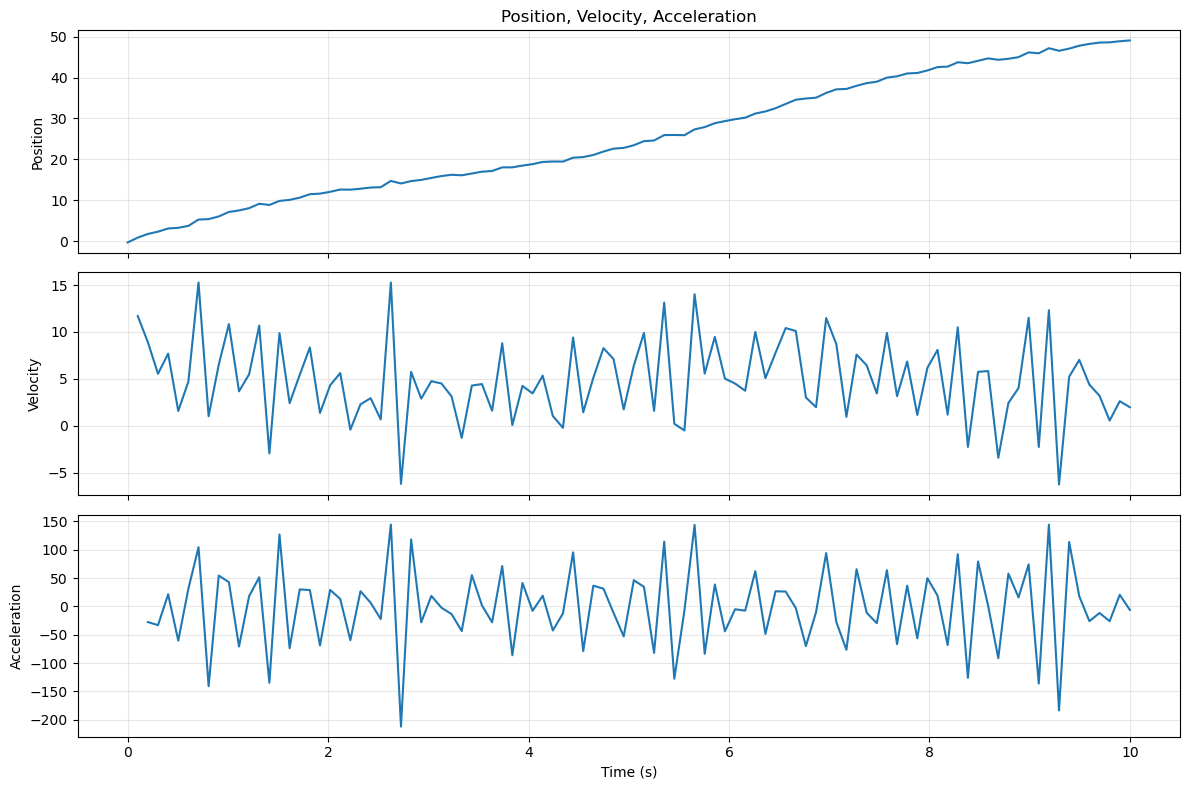

In [29]:
# Calculate velocity
dt = np.mean(np.diff(t_pos))  # Time step
df_pos['velocity'] = df_pos['position'].diff() / dt

# Calculate acceleration
df_pos['acceleration'] = df_pos['velocity'].diff() / dt

# Plot
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axes[0].plot(df_pos['time'], df_pos['position'])
axes[0].set_ylabel('Position')
axes[0].set_title('Position, Velocity, Acceleration')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df_pos['time'], df_pos['velocity'])
axes[1].set_ylabel('Velocity')
axes[1].grid(True, alpha=0.3)

axes[2].plot(df_pos['time'], df_pos['acceleration'])
axes[2].set_ylabel('Acceleration')
axes[2].set_xlabel('Time (s)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Smooth derivative with Savitzky-Golay

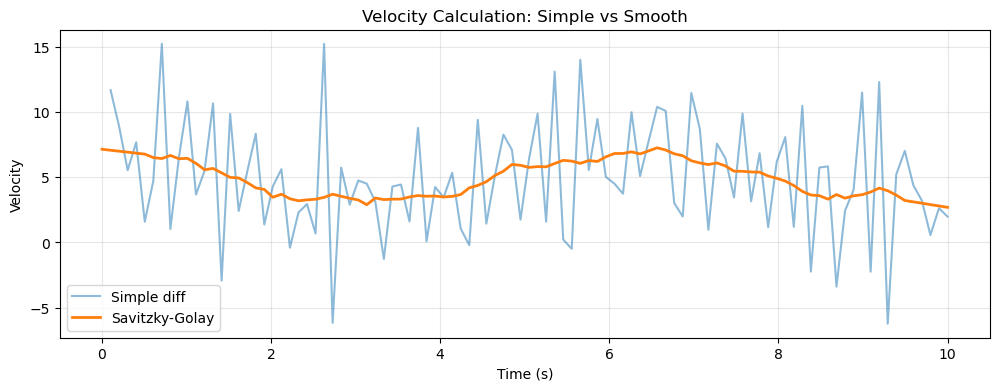

In [30]:
# Smooth velocity calculation
velocity_smooth = signal.savgol_filter(
    df_pos['position'].values,
    window_length=11,
    polyorder=2,
    deriv=1,  # First derivative
    delta=dt
)

plt.figure(figsize=(12, 4))
plt.plot(df_pos['time'], df_pos['velocity'], alpha=0.5, label='Simple diff')
plt.plot(df_pos['time'], velocity_smooth, linewidth=2, label='Savitzky-Golay')
plt.xlabel('Time (s)')
plt.ylabel('Velocity')
plt.title('Velocity Calculation: Simple vs Smooth')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Summary

In this notebook we covered:
- Signal filtering (low-pass, high-pass, band-pass)
- Smoothing techniques (moving average, Savitzky-Golay, Gaussian)
- Peak detection
- Working with datetime data (parsing, slicing, extraction)
- Resampling (upsampling, downsampling)
- Rolling window statistics
- Calculating derivatives (shift, diff, smooth derivatives)

**Next notebook:** SciPy Statistics

In [31]:
print("Notebook 4 complete!")

Notebook 4 complete!
